In [1]:
import os
# set available device
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import subgraph, remove_isolated_nodes, degree, index_to_mask, mask_to_index, to_dense_adj
from tqdm import tqdm
import pandas as pd
import math
from scipy.special import softmax
from typing import Union, List, Tuple, Callable
from functools import partial


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Useful functions

### miscellaneous functions

In [3]:
def get_oracle_rationale(graph: Union[Batch, Data]) -> Union[Data, Batch]:
    """Given original graph `graph`, return its non-reduced oracle rationale.
    """
    rationale = graph.clone()
    rationale.edge_index = graph.edge_index[:, graph.ground_truth_mask]
    rationale.edge_attr = graph.edge_attr[graph.ground_truth_mask]
    return rationale

def fill_graph(subgraph: Union[Data, Batch], graph: Union[Data, Batch], G: VGAE, fill_times: int = 1) -> List[Union[Data, Batch]]:
    """
        Given original graph `graph` and non-reduced subgraph `subgraph`, 
        return a list of non-reduced filled graphs based on `subgraph`, refering to `graph`.
    """
    graph, subgraph = graph.to(device), subgraph.to(device)
    input_is_batch = True
    if type(graph) is Data:
        input_is_batch = False
        graph = Batch.from_data_list([graph])
        subgraph = Batch.from_data_list([subgraph])
    assert graph.num_graphs == subgraph.num_graphs

    graph_edge_indices = torch.split(graph.edge_index, degree(graph.batch[graph.edge_index[0]]).long().tolist(), dim=1)
    subgraph_edge_indices = torch.split(subgraph.edge_index, degree(subgraph.batch[subgraph.edge_index[0]]).long().tolist(), dim=1)
    edge_ratio = torch.tensor([gse.size(1) / ge.size(1) for gse, ge in zip(subgraph_edge_indices, graph_edge_indices)], device=device)

    mu, log_var, z = G.encode(x=graph.x, in_edge_index=subgraph.edge_index, in_edge_attr=subgraph.edge_attr)
    _, _, cond_z = G.encode(x=graph.x, in_edge_index=graph.edge_index, in_edge_attr=graph.edge_attr)
    z = torch.cat([z, cond_z], dim=1)

    filled_graphs = []
    for _ in range(fill_times):
        fake_edge_index, fake_edge_prob, fake_edge_attr, _ = G.fill(z=z, preserved_edge_index=subgraph.edge_index, preserved_edge_ratio=edge_ratio, batch=graph.batch, pos=graph.pos, neg_edge_index=None, threshold=False)
        filled_graph = graph.clone()
        filled_graph.edge_index = fake_edge_index
        filled_graph.edge_attr = fake_edge_attr
        filled_graphs.append(filled_graph if input_is_batch else filled_graph[0])

    return filled_graphs

def reduce_graph(graphs: Union[Data, Batch], inplace: bool = False) -> Union[Data, Batch]:
    """return a new graph with isolated nodes removed."""
    input_is_batch = True
    if type(graphs) is Data:
        input_is_batch = False
        graphs = [graphs]
    else:
        graphs: List[Data] = graphs.to_data_list()

    reduced_graphs = []
    for graph in graphs:
        if not inplace:
            graph = graph.clone()
        edge_index, edge_attr, node_mask = remove_isolated_nodes(graph.edge_index, graph.edge_attr, graph.num_nodes)
        graph.edge_index = edge_index
        graph.edge_attr = edge_attr
        graph.x = graph.x[node_mask]
        if hasattr(graph, 'pos'):
            graph.pos = graph.pos[node_mask]
        reduced_graphs.append(graph)
    return Batch.from_data_list(reduced_graphs) if input_is_batch else reduced_graphs[0]

def repeat_interleave_as(obj: torch.Tensor, ref: torch.Tensor, dim: int = 0) -> torch.Tensor:
    """Repeat each element of `obj` as many times as the corresponding element in `ref`.
    """
    if obj.size(dim) < ref.size(dim):
        assert ref.size(dim) % obj.size(dim) == 0
        obj = obj.repeat_interleave(ref.size(dim) // obj.size(dim), dim=dim)
    return obj

### sample functions

In [4]:
def sample_subgraphs_random(graph: Data, n_total: Union[int, float] = 1.0, n_pos: Union[int, float] = 0.5, n_samples: int = 10, on_edges: bool = True) -> Batch:
    """Randomly sample `n_samples` subgraphs with a total of `n_total` edges(or nodes) and `n_pos` positive edges(or nodes).

    Args:
        graph (Data): The original graph.
        n_total (Union[int, float]): The total number of edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_pos (Union[int, float]): The number of positive edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_samples (int): The number of sampled subgraphs.
        on_edges (bool): Whether to sample on edges or nodes, default to True, i.e. sample on edges.
    """
    device = graph.edge_index.device

    pos_mask = graph.ground_truth_mask

    if on_edges:
        total = graph.num_edges
    else:
        pos_mask = index_to_mask(graph.edge_index[:, pos_mask].unique(), size=graph.num_nodes)
        total = graph.num_nodes

    total_pos = pos_mask.sum().item()
    total_neg = total - total_pos

    if isinstance(n_total, float):
        n_total = round(n_total * total_pos)
    if isinstance(n_pos, float):
        n_pos = round(n_pos * total_pos)
    n_neg = n_total - n_pos
    if n_pos > total_pos or n_neg > total_neg or n_total < n_pos:
        return None

    sample_mask = torch.zeros(n_samples, total, dtype=torch.bool, device=device)

    pos_sample_mask = torch.zeros(n_samples, total_pos, dtype=torch.bool, device=device)
    rand_perm = torch.randn(n_samples, total_pos, device=device).argsort(dim=1)
    pos_sample_mask.scatter_(1, rand_perm[:, :n_pos], True)
    sample_mask[:, pos_mask] = pos_sample_mask

    neg_sample_mask = torch.zeros(n_samples, total_neg, dtype=torch.bool, device=device)
    rand_perm = torch.randn(n_samples, total_neg, device=device).argsort(dim=1)
    neg_sample_mask.scatter_(1, rand_perm[:, :n_neg], True)
    sample_mask[:, ~pos_mask] = neg_sample_mask

    if not on_edges:
        sample_mask = sample_mask[:, graph.edge_index[0]] & sample_mask[:, graph.edge_index[1]]

    subgraphs = []
    for i in range(n_samples):
        subgraph = graph.clone()
        delattr(subgraph, 'ground_truth_mask')
        subgraph.edge_index = subgraph.edge_index[:, sample_mask[i]]
        subgraph.edge_attr = subgraph.edge_attr[sample_mask[i]]
        subgraphs.append(subgraph)
    subgraphs = Batch.from_data_list(subgraphs)
    return subgraphs

def sample_subgraphs_connected(graph: Data, n_total: Union[int, float] = 1.0, n_pos: Union[int, float] = 0.5, n_samples: int = 10, on_edges: bool = True) -> Batch:
    """Randomly sample `n_samples` *connected* subgraphs with a total of `n_total` edges(or nodes) and `n_pos` positive edges(or nodes).

    Args:
        graph (Data): The original graph.
        n_total (Union[int, float]): The total number of edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_pos (Union[int, float]): The number of positive edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_samples (int): The number of sampled subgraphs.
        on_edges (bool): Whether to sample on edges or nodes, default to True, i.e. sample on edges.
    """
    device = graph.edge_index.device

    pos_mask = graph.ground_truth_mask

    if on_edges:
        total = graph.num_edges
    else:
        pos_mask = index_to_mask(graph.edge_index[:, pos_mask].unique(), size=graph.num_nodes)
        total = graph.num_nodes

    total_pos = pos_mask.sum().item()
    total_neg = total - total_pos

    if isinstance(n_total, float):
        n_total = round(n_total * total_pos)
    if isinstance(n_pos, float):
        n_pos = round(n_pos * total_pos)
    n_neg = n_total - n_pos
    if n_pos > total_pos or n_neg > total_neg or n_total < n_pos:
        return None

    subgraphs = []
    while len(subgraphs) < n_samples:
        sample_mask = torch.zeros(total, dtype=torch.bool, device=device)
        connected_mask = torch.zeros(total, dtype=torch.bool, device=device)  # indicate whether an edge(or a node) is connected to selected edges(or nodes)
        while (n_sampled := sample_mask.sum()) < n_total:
            available_mask = pos_mask.clone() if n_sampled < n_pos else (~pos_mask).clone()
            available_mask &= ~sample_mask
            if n_sampled > 0:
                available_mask &= connected_mask
            if not available_mask.any():
                break
            available_indices = available_mask.nonzero().view(-1)
            new_index = available_indices[torch.randint(0, len(available_indices), ())]
            sample_mask[new_index] = True
            if on_edges:
                new_edge = graph.edge_index[:, new_index]
                connected_mask |= (graph.edge_index[0] == new_edge[0]) | (graph.edge_index[1] == new_edge[0]) | (graph.edge_index[0] == new_edge[1]) | (graph.edge_index[1] == new_edge[1])
            else:
                connected_mask[graph.edge_index[:, (graph.edge_index[0] == new_index) | (graph.edge_index[1] == new_index)].unique()] = True

        if n_sampled < n_total:
            continue

        subgraph = graph.clone()
        delattr(subgraph, 'ground_truth_mask')
        if not on_edges:  # sample on nodes, convert node mask to edge mask
            sample_mask = sample_mask[graph.edge_index[0]] & sample_mask[graph.edge_index[1]]
        subgraph.edge_index = subgraph.edge_index[:, sample_mask]
        subgraph.edge_attr = subgraph.edge_attr[sample_mask]
        subgraphs.append(subgraph)
    subgraphs = Batch.from_data_list(subgraphs)
    return subgraphs

### score functions

In [5]:
@torch.no_grad()
def score_cross_entropy(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module) -> torch.Tensor:
    """Assume `subgraph` is a non-reduced subgraph of `graph`."""
    full_preds = gnn(graphs.to(device))
    sub_preds = gnn(reduce_graph(subgraphs).to(device))
    full_probs = torch.softmax(full_preds, dim=-1)
    full_probs = repeat_interleave_as(full_probs, sub_preds)
    scores = - torch.nn.functional.cross_entropy(sub_preds, full_probs, reduction='none')
    return scores

@torch.no_grad()
def score_confidence(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module) -> torch.Tensor:
    """Assume `subgraph` is a non-reduced subgraph of `graph`."""
    sub_preds = gnn(reduce_graph(subgraphs).to(device))
    sub_probs = torch.softmax(sub_preds, dim=-1)
    y = repeat_interleave_as(graphs.y.to(device), sub_probs)
    scores = sub_probs.gather(dim=-1, index=y.unsqueeze(-1)).squeeze(-1)
    return scores

def random_deletion(graph: Data, subgraph: Data, n_del: Union[int, float], n_samples: int = 1, on_edges: bool = True) -> Batch:
    """Assume `subgraph` is a non-reduced subgraph of `graph`."""
    device = graph.edge_index.device

    total = graph.num_edges if on_edges else graph.num_nodes
    if on_edges:
        neg_mask = (graph.edge_index[:, :, None] != subgraph.edge_index[:, None, :]).any(0).all(-1)
    else:
        neg_mask = ~index_to_mask(subgraph.edge_index.unique(), size=graph.num_nodes)
    total_neg = neg_mask.sum().item()
    if isinstance(n_del, float):
        n_del = round(n_del * total_neg)

    sample_mask = torch.ones(n_samples, total, dtype=torch.bool, device=device)
    neg_sample_mask = torch.ones(n_samples, total_neg, dtype=torch.bool, device=device)
    rand_perm = torch.randn(n_samples, total_neg, device=device).argsort(dim=1)
    neg_sample_mask.scatter_(1, rand_perm[:, :n_del], False)
    sample_mask[:, neg_mask] = neg_sample_mask

    if not on_edges:
        sample_mask = sample_mask[:, graph.edge_index[0]] & sample_mask[:, graph.edge_index[1]]

    subgraphs = []
    for i in range(n_samples):
        subgraph = graph.clone()
        delattr(subgraph, 'ground_truth_mask')
        subgraph.edge_index = subgraph.edge_index[:, sample_mask[i]]
        subgraph.edge_attr = subgraph.edge_attr[sample_mask[i]]
        subgraphs.append(subgraph)
    subgraphs = Batch.from_data_list(subgraphs)
    return subgraphs

@torch.no_grad()
def score_random_deletion(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module, n_del: Union[int, float] = 1, n_samples: int = 1, on_edges: bool = True) -> torch.Tensor:
    aug_subgraphs = []
    for subgraph, graph in zip(subgraphs.to_data_list(), graphs.to_data_list()):
        aug_subgraphs.extend(random_deletion(graph, subgraph, n_del, n_samples, on_edges).to_data_list())
    aug_subgraphs = Batch.from_data_list(aug_subgraphs)
    scores = score_confidence(aug_subgraphs, graphs, gnn)
    return scores

## OOD effect evaluation

In [6]:
def evaluate(test_dataset, gnn, sample_func, score_funcs: List[Callable[[Batch, Batch, torch.nn.Module], torch.Tensor]]) -> None:
    metrics = []
    scores_list = [[] for _ in range(len(score_funcs))]
    for batch in tqdm(DataLoader(test_dataset, batch_size=1, shuffle=False)):
        graph = batch[0]
        _metrics, subgraphs = sample_func(graph=graph)
        metrics.extend(_metrics)
        for i, score_func in enumerate(score_funcs):
            scores = []
            for subgraph in subgraphs:
                scores.append(score_func(subgraph, Batch.from_data_list([graph] * subgraph.num_graphs), gnn).mean(0).item())
            scores_list[i].extend(scores)
    return metrics, scores_list

def plot_corr(metrics, scores, metric_name: str = '', label: str = '', with_line: bool = False):
    corr_coef = np.corrcoef(metrics, scores)[0, 1]
    corr = f'{corr_coef:.3f}'
    if label:
        label += ',' + corr
    else:
        plt.title('corr = ' + corr)
    plt.xlabel(metric_name)
    plt.ylabel('score')
    plt.scatter(metrics, scores, s=10, label=label)
    if with_line:
        plt.plot(metrics, scores, alpha=0.1, c='k')

### MNIST

In [6]:
from gnn import MNISTNet
import networkx as nx
from torch_geometric.utils import to_networkx


gnn_path = "./param/gnns/mnist_net.pt"
data_path = './data/MNIST'
generator_path = './param/cg/mnist-default-[1.,5.,1.,1e-4]/generator/best.pkl'

gnn = torch.load(gnn_path, map_location=device).eval()
# G: VGAE = torch.load(generator_path, map_location=device)

test_dataset = MNISTSuperpixels(data_path, False, transform=Cartesian(cat=False, max_value=9))
row, col = test_dataset.data.edge_index
node_mask = test_dataset.data.x.squeeze() > 0
edge_mask = node_mask[row] & node_mask[col]
test_dataset.data.ground_truth_mask = edge_mask
test_dataset.slices['ground_truth_mask'] = test_dataset.slices['edge_index'].clone()

def draw(g: Union[Data, int], edge_order: bool = False):
    if isinstance(g, int):
        g = test_dataset[g]
    node_mask = g.x.squeeze(1) > 0
    pos = dict(enumerate(g.pos.cpu().numpy()))
    g_nx = to_networkx(g).to_undirected()
    g_nx.remove_nodes_from(list(nx.isolates(g_nx)))
    print('Connected component(s):', nx.number_connected_components(g_nx))
    if edge_order:
        fig = plt.figure(1, figsize=(20, 20))
        edge_labels = dict((tuple(e), str(i)) for i, e in enumerate(g.edge_index.t().tolist()))
    g = to_networkx(g).to_undirected()
    nx.draw_networkx(g, pos=pos, node_color=np.array(['lightblue', 'red'])[node_mask.cpu().numpy().astype(int)], with_labels=False)
    if edge_order:
        nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, font_size=8)

def sampling(sample_func, graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 100, n_points: int = 20, on_edges: bool = True) -> Tuple[List[float], List[Batch]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    for n_pos in np.linspace(0, min(1., n_total), n_points):
        n_pos = n_pos.item()
        subgraph = sample_func(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges)
        if subgraph is None:
            print('Warning')
            continue
        if n_pos > 1.0:
            metrics.append(n_pos / n_total)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

#### Case study

In [ ]:
graph = test_dataset[0]
label = graph.y.item()
print(f'{label = }')
sample_func = partial(sampling, sample_func=sample_subgraphs_random, n_total=1.0, n_samples=1, n_points=20, on_edges=False)
metrics, subgraphs = sample_func(graph=graph)
gt = subgraphs[-20][0]
perturbs = random_deletion(graph, gt, 0.7, 100)
reduced_perturbs = reduce_graph(perturbs)
try:
    preds = gnn(reduced_perturbs)
except Exception as e:
    import traceback
    traceback.print_exc()
probs = preds.softmax(-1)
scores = probs[:, label]
score = scores.mean(0).item()
check = reduce_graph(gt)
print(check)
draw(check)

In [ ]:
draw(reduced_perturbs[0])

In [ ]:
scores = [score_random_deletion(subgraph, graph, gnn, 800, 500).mean(0).item() for subgraph in subgraphs]
plot_corr(metrics, scores, 'precision/recall')

In [ ]:
scores = [score_confidence(subgraph, graph, gnn).mean(0).item() for subgraph in subgraphs]
plot_corr(metrics, scores, 'precision/recall')

#### Full Test

In [ ]:
sample_func = partial(sampling, sample_func=sample_subgraphs_random, n_total=1.0, n_samples=100, n_points=20, on_edges=False)
metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [score_confidence])

In [ ]:
sample_func = partial(sampling, sample_func=sample_subgraphs_random, n_total=1.0, n_samples=100, n_points=20, on_edges=False)
metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [partial(score_random_deletion, n_del_edges=0.5, n_samples=1)])

In [ ]:
i = 5
plot_corr(metrics[20*i:20*(i+1)], scores_conf[20*i:20*(i+1)], 'precision/recall')

In [ ]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')
plt.savefig('./figure/mnist_random_1.0.png')

In [ ]:
on_edges = False
n_original = 50
n_level = 20
n_sub = 10
n_perturb = 50
for r_perturb in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.figure(figsize=(10, 5))
    for r_sub in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
        sample_func = partial(sampling, sample_func=sample_subgraphs_random, n_total=r_sub, n_samples=n_sub, n_points=n_level, on_edges=on_edges)
        metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:n_original]], gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=n_perturb, on_edges=on_edges)])
        scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
        scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
        plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall', label=f'{r_sub}', with_line=True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'./figure/mnist_random_nodes_del_{r_perturb}.png')
    plt.close()

In [ ]:
plt.figure(figsize=(10, 5))
for n_total in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    sample_func = partial(sampling, sample_func=sample_subgraphs_random, n_total=n_total, n_samples=100, n_points=20, on_edges=False)
    metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [score_confidence])
    scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
    scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
    plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall', label=f'{n_total}', with_line=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f'./figure/mnist_random_nodes.png')
plt.close()

#### Full test (DSE)

In [ ]:
score_confidence_with_fill_in = lambda gs, s, gnn: score_confidence(fill_graph(gs, Batch.from_data_list([s] * gs.num_graphs), fill_times=1)[0], s, gnn)
metrics, (scores_conf, ) = evaluate(test_dataset[:1000], gnn, [score_confidence_with_fill_in], n_samples=100)

In [ ]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')

### BA-3Motif

In [6]:
from gnn import BA3MotifNet
from datasets import BA3Motif
import networkx as nx
from torch_geometric.utils import to_networkx

gnn_path = "./param/gnns/ba3_net.pt"
data_path = './data/BA3'

gnn = torch.load(gnn_path, map_location=device).eval()

train_dataset = BA3Motif(data_path, mode='training')
test_dataset = BA3Motif(data_path, mode='testing')

ground_truth_size = {0: 6, 1: 12, 2: 5}
ground_truth_size_nodes = {0: 5, 1: 9, 2: 5}
gt_sizes = [ground_truth_size[data.y.item()] for data in test_dataset]

def draw(g: Union[Data, int]):
    if isinstance(g, int):
        g = test_dataset[g]
    nx_g = to_networkx(g).to_undirected()
    if g.pos is not None:
        pos = dict(enumerate(g.pos.numpy()))
    else:
        pos = nx.spring_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True)

def sampling(sample_func, graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 20, on_edges: bool = True) -> Tuple[List[float], List[Batch]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    gt_size = ground_truth_size[graph.y.item()] if on_edges else ground_truth_size_nodes[graph.y.item()]
    n_total = round(n_total * gt_size)
    for n_pos in range(min(gt_size, n_total) + 1):
        subgraph = sample_func(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges)
        if subgraph is None:
            continue
        if n_total > gt_size:
            metrics.append(n_pos / gt_size)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

Class: 1


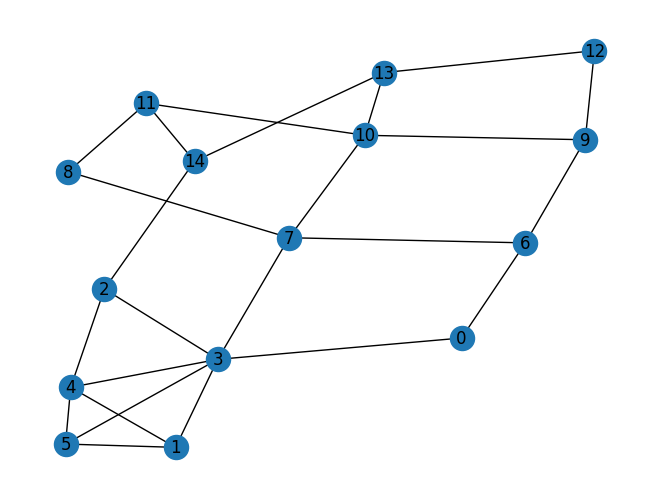

In [7]:
g = test_dataset[6]
print('Class:', g.y.item())
draw(g)

In [ ]:
sample_func = partial(sampling, sample_func=sample_subgraphs_connected, n_total=1.0, n_samples=20, on_edges=True)
metrics, (scores_conf, ) = evaluate(test_dataset, gnn, sample_func, [score_confidence])
partial(score_random_deletion, n_del=r_perturb, n_samples=n_perturb, on_edges=on_edges)

In [17]:
sample_func = partial(sampling, sample_func=sample_subgraphs_connected, n_total=1.0, n_samples=20, on_edges=True)
metrics, (scores_conf, ) = evaluate(test_dataset, gnn, sample_func, [partial(score_random_deletion, n_del=5, n_samples=20)])

100%|██████████| 400/400 [18:48<00:00,  2.82s/it]


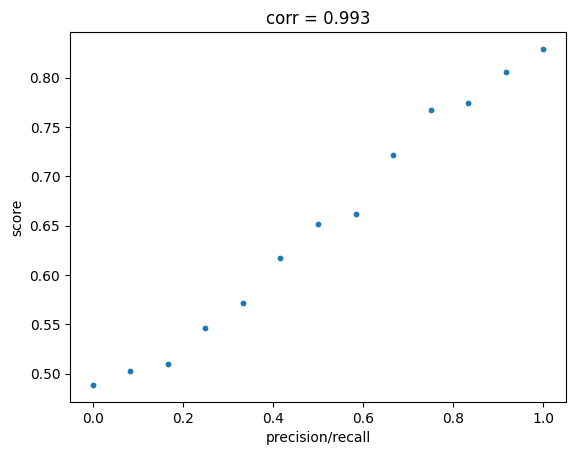

In [24]:
i = 10
cum_gt_size = sum(gt_sizes[:i]) + i
plot_corr(metrics[cum_gt_size:cum_gt_size+gt_sizes[i]+1], scores_conf[cum_gt_size:cum_gt_size+gt_sizes[i]+1], 'precision/recall')

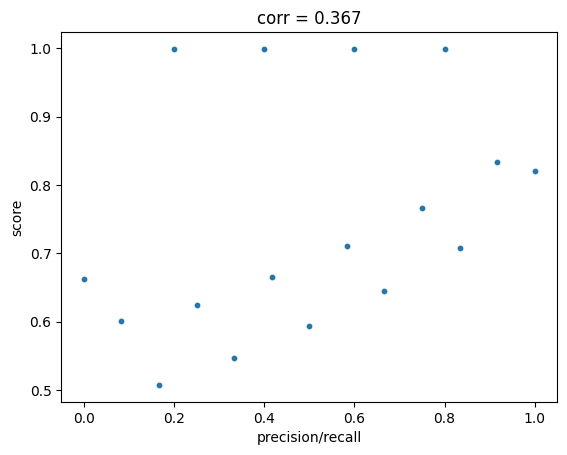

In [26]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')

#### Full test

In [29]:
for label, gt_size in ground_truth_size.items():
    for r_perturb in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
        indices = [i for i, data in enumerate(test_dataset) if data.y.item() == label]
        for n_total in [1., 1.5, 2.0]:
            sample_func = partial(sampling, sample_func=sample_subgraphs_connected, n_total=n_total, n_samples=20)
            metrics, (scores_conf, ) = evaluate(test_dataset[indices], gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=20)])
            scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
            scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
            plot_corr(scores_avg.metric, scores_avg.score, 'recall', label=f'{n_total}', with_line=True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./figure/ba3_gt-{gt_size}_connect_del_{r_perturb}.png')
        plt.close()

100%|██████████| 125/125 [03:32<00:00,  1.70s/it]


#### Graphon

In [ ]:
from torch_geometric.utils import dense_to_sparse, to_dense_adj, to_undirected
import copy


def align_graphs(graphs: List[np.ndarray],
                 padding: bool = False, N: int = 0) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees
    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        max_num = max(max_num, N)

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

    return aligned_graphs, normalized_node_degrees, max_num, min_num

def universal_svd(aligned_graphs: List[np.ndarray], threshold: float = 2.02) -> np.ndarray:
    """
    Estimate a graphon by universal singular value thresholding.
    Reference:
    Chatterjee, Sourav.
    "Matrix estimation by universal singular value thresholding."
    The Annals of Statistics 43.1 (2015): 177-214.
    :param aligned_graphs: a list of (N, N) adjacency matrices
    :param threshold: the threshold for singular values
    :return: graphon: the estimated (r, r) graphon model
    """
    aligned_graphs = torch.from_numpy(np.array(aligned_graphs)).float().to( "cuda" )
    num_graphs = aligned_graphs.size(0)

    if num_graphs > 1:
        sum_graph = torch.mean(aligned_graphs, dim=0)
    else:
        sum_graph = aligned_graphs[0, :, :]  # (N, N)

    num_nodes = sum_graph.size(0)

    u, s, v = torch.svd(sum_graph)
    singular_threshold = threshold * (num_nodes ** 0.5)
    binary_s = torch.lt(s, singular_threshold)
    s[binary_s] = 0
    graphon = u @ torch.diag(s) @ torch.t(v)
    graphon[graphon > 1] = 1
    graphon[graphon < 0] = 0
    diagonal_mask = torch.eye(*graphon.shape, device=graphon.device).bool()
    graphon.masked_fill_(diagonal_mask, 0)
    graphon = graphon.cpu().numpy()
    torch.cuda.empty_cache()
    return graphon

def get_adjmatrices_groupby_class(dataset: BA3Motif) -> dict[int, List[np.ndarray]]:
    data_list = list(dataset)
    labels = sorted({data.y.item() for data in data_list})

    cls_adjs = {cls: [] for cls in labels}
    for data in data_list:
        adj = to_dense_adj(to_undirected(data.edge_index))[0].numpy()
        cls_adjs[data.y.item()].append(adj)
    return cls_adjs

In [ ]:
cls_adjs = get_adjmatrices_groupby_class(dataset=train_dataset)

In [ ]:
import random
idx = np.random.choice(len(aligned_adjs))

In [ ]:
plt.imshow(cls_adjs[cls][idx], cmap='gray')
# plt.imshow(aligned_adjs[idx], cmap='gray')

In [ ]:
cls = 1
all_adjs = sum(cls_adjs.values(), [])
aligned_adjs, _, _, _ = align_graphs(all_adjs, padding=True)
graphon = universal_svd(aligned_adjs, threshold=0.1)
plt.imshow(graphon, cmap='gray')

In [ ]:
def sample_from_graphon(graphon: np.ndarray):
    sample_adj = (np.random.rand(*graphon.shape) < graphon).astype(np.int32)
    # sample_adj = (graphon > 0.25).astype(np.int32)
    sample_adj = np.triu(sample_adj)
    sample_adj = sample_adj + sample_adj.T - np.diag(np.diag(sample_adj))
    sample_adj = sample_adj[sample_adj.sum(axis=1) != 0]
    sample_adj = sample_adj[:, sample_adj.sum(axis=0) != 0]
    A = torch.from_numpy(sample_adj)
    edge_index, _ = dense_to_sparse(A)
    num_nodes = int(torch.max(edge_index)) + 1
    graph = Data(edge_index=edge_index)
    return graph

graph = sample_from_graphon(graphon)
draw(graph)

#### OOD Block

In [7]:
from ood_block import OODBlock, VariationalGCNEncoder

ood_evaluator: OODBlock = torch.load('param/ood/ba3.pth', map_location=device)

for label, gt_size in ground_truth_size.items():
    indices = [i for i, data in enumerate(test_dataset) if data.y.item() == label]
    for n_pos in range(gt_size + 1):
        rows = []
        for n_del in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
            for batch in tqdm(DataLoader(test_dataset[indices], batch_size=1, shuffle=False)):
                graph = batch[0]
                subgraphs = sample_subgraphs_connected(graph, n_total=gt_size, n_pos=n_pos, n_samples=20)
                if subgraphs is None:
                    continue
                perturbs = Batch.from_data_list(sum([random_deletion(graph, gs, n_del=n_del, n_samples=20).to_data_list() for gs in subgraphs.to_data_list()], []))
                reduced_perturbs = reduce_graph(perturbs)
                loss, auc, ap = ood_evaluator.evaluate([reduced_perturbs], device=device)
                rows.append([n_del, loss, auc, ap])
        ood_df = pd.DataFrame(rows, columns=['n_del', 'loss', 'auc', 'ap'])
        ood_df = ood_df.groupby('n_del', as_index=False).mean()
        plt.xlabel('n_del')
        for metric in ['loss', 'auc', 'ap']:
            plt.scatter(ood_df['n_del'], ood_df[metric], label=metric)
            plt.plot(ood_df['n_del'], ood_df[metric], alpha=0.1, c='k')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./figure/ba3_gt-{gt_size}_connect_n_pos-{n_pos}_ood.png')
        plt.close()

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


### Mutagenicity

In [167]:
from gnn import MutagNet
from data import Mutagenicity
import networkx as nx
from torch_geometric.utils import to_networkx

gnn_path = "./param/gnns/mutag_net.pt"
data_path = './data/Mutag'

gnn = torch.load(gnn_path, map_location=device).eval()

train_dataset = Mutagenicity(data_path, mode='training')
test_dataset = Mutagenicity(data_path, mode='testing')

colors = ['orange','red','lime','green','blue','orchid','darksalmon','darkslategray','gold','bisque','tan','lightseagreen','indigo','navy']
def draw(g: Union[Data, int]):
    if isinstance(g, int):
        g = test_dataset[g]
    nx_g = to_networkx(g)
    if g.pos is not None:
        pos = dict(enumerate(g.pos.numpy()))
    else:
        pos = nx.kamada_kawai_layout(nx_g)
    node_colors = [colors[l] for l in g.z.tolist()]
    node_labels = {i: Mutagenicity.node_label_map[l] for i, l in enumerate(g.z.tolist())}
    edge_list = g.edge_index.t().tolist()
    edge_colors = ['red' if mask else 'black' for mask in g.ground_truth_mask.tolist()]
    nx.draw_networkx(nx_g, pos=pos, with_labels=True, node_color=node_colors, labels=node_labels, edgelist=edge_list, edge_color=edge_colors, arrows=False)

def sampling(sample_func, graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 20, on_edges: bool = True) -> Tuple[List[float], List[Batch]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    gt_size = ground_truth_size[graph.y.item()] if on_edges else ground_truth_size_nodes[graph.y.item()]
    n_total = round(n_total * gt_size)
    for n_pos in range(min(gt_size, n_total) + 1):
        subgraph = sample_func(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges)
        if subgraph is None:
            continue
        if n_total > gt_size:
            metrics.append(n_pos / gt_size)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

mutagenic


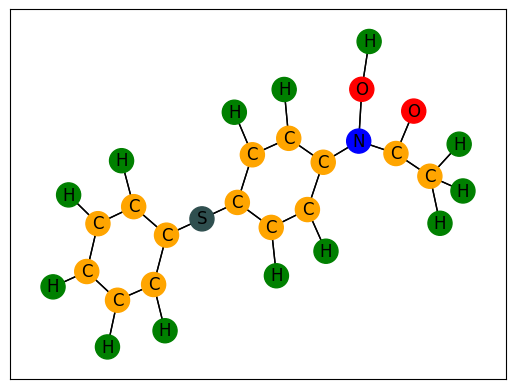

In [166]:
i = np.random.randint(0, len(test_dataset) - 1)
g = test_dataset[i]
print(('' if g.y.item() == 0 else 'non') + 'mutagenic')
draw(i)

In [177]:
y = ~np.array([g.y.item() for g in train_dataset], dtype=bool)
has_no2_nh2 = np.array([g.ground_truth_mask.any().item() for g in train_dataset])
print(has_no2_nh2[~y].mean())

0.17576564580559254


## Comparison
Labels, Original pred, oracle rationale pred

In [ ]:
labels = []
original_preds = []
rationale_preds = []
filled_rationale_preds = []
for graphs in tqdm(DataLoader(test_dataset, batch_size=256, shuffle=False)):
    rationales = get_oracle_rationale(graphs)
    filled_rationales_list = fill_graph(graphs, rationales, fill_times=fill_times)

    labels.append(graphs.y.squeeze())
    with torch.no_grad():
        original_preds.append(gnn(graphs))
        rationale_preds.append(gnn(reduce_graph(rationales)))
        filled_rationale_preds.append(torch.stack([gnn(reduce_graph(filled_rationales)) for filled_rationales in filled_rationales_list]).mean(0))

labels = torch.cat(labels).cpu().numpy()
original_preds = torch.cat(original_preds).cpu().numpy()
rationale_preds = torch.cat(rationale_preds).cpu().numpy()
filled_rationale_preds = torch.cat(filled_rationale_preds).cpu().numpy()

### Confidence w.r.t a specified class

#### Logits

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls
    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Logits of class {cls})')
    ax.set_ylim(-30, 1)
    x = range(cls_mask.sum())
    ax.scatter(x, original_preds[cls_mask, cls], label='original', s=2)
    ax.scatter(x, rationale_preds[cls_mask, cls], label='rationale', s=2)
    ax.legend()

#### Probabilities

In [ ]:
original_probs = softmax(original_preds, axis=-1)
rationale_probs = softmax(rationale_preds, axis=-1)

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls
    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Probabilities of class {cls})')
    x = range(cls_mask.sum())
    ax.scatter(x, original_probs[cls_mask, cls], label='original', s=2)
    ax.scatter(x, rationale_probs[cls_mask, cls], label='rationale', s=2)
    ax.legend()

### Performace

#### Class-wise

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls

    cls_original_probs = original_probs[cls_mask]
    cls_rationale_probs = rationale_probs[cls_mask]
    cls_original_acc = (cls_original_probs.argmax(-1) == cls).mean()
    cls_rationale_acc = (cls_rationale_probs.argmax(-1) == cls).mean()

    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Averaged prob. distribution of class {cls}')
    x = range(10)
    ax.bar(x, cls_original_probs.mean(axis=0), label=f'original (ACC = {cls_original_acc:.4f})')
    ax.bar(x, cls_rationale_probs.mean(axis=0), label=f'rationale (ACC = {cls_rationale_acc:.4f})')
    ax.legend()

#### Overall

In [ ]:
original_acc = (original_probs.argmax(-1) == labels).mean()
rationale_acc = (rationale_probs.argmax(-1) == labels).mean()
print(f'original ACC = {original_acc}')
print(f'rationale ACC = {rationale_acc}')

## Playground

In [ ]:
x = np.linspace(0, 1, 100)
y = 0.5 * x + np.random.normal(0, 0.005, size=x.shape)
plt.xlabel('Prec(·,Gs*)')
plt.ylabel('s(·)')
plt.yticks([])
plt.scatter(x, y, s=2, label='0.75')
plt.scatter(x, y, s=2, label='1.0')
plt.scatter(x, y, s=2, label='1.5')
plt.scatter(x, y, s=2, label='2.0')
plt.legend()